# Latincom 2025 - Anomaly Detection in Industrial IoT (IIoT)

Dataset: https://ieee-dataport.org/documents/bruriiot-dataset-network-anomaly-detection-iiot-enhanced-feature-engineering-approach



Tasks:
- balancear OK
- tempos OK
- confusion matrix OK
- testar com um tipo de ataque (mirai)
- testar retirando o ip
- tcp e udp

In [1]:
# install dependencies
!pip install xgboost pyimpetus Boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.1 MB/s eta 0:00:00


## Downloading dataset

In [ ]:
# download BRUIIoT.csv from drive
!gdown --id 18jejnWLvTJkUnzCGDsU9xaeNIDS2i0G1

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=18jejnWLvTJkUnzCGDsU9xaeNIDS2i0G1
From (redirected): https://drive.google.com/uc?id=18jejnWLvTJkUnzCGDsU9xaeNIDS2i0G1&confirm=t&uuid=1b9e5204-2207-4a6d-be6b-b967db715b38
To: /content/BRUIIoT.csv
100% 3.00G/3.00G [00:41<00:00, 71.8MB/s]


In [5]:
# download BRUIIoT_test.csv from drive
!gdown --id 1TCesDO93j-Ob4B08b03GWEPAqcr20O81

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TCesDO93j-Ob4B08b03GWEPAqcr20O81
From (redirected): https://drive.google.com/uc?id=1TCesDO93j-Ob4B08b03GWEPAqcr20O81&confirm=t&uuid=08cb019b-e1ab-43a2-9065-46290f89d215
To: /content/BRUIIoT_test.csv
100% 604M/604M [00:04<00:00, 128MB/s]


In [6]:
# download BRUIIoT_train.csv from drive
!gdown --id 1r1fPPZQRoOT7Be7nG0xvaWaZuTuj-pE8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1r1fPPZQRoOT7Be7nG0xvaWaZuTuj-pE8
From (redirected): https://drive.google.com/uc?id=1r1fPPZQRoOT7Be7nG0xvaWaZuTuj-pE8&confirm=t&uuid=a817853f-3739-41ea-a286-7ba0a6c05050
To: /content/BRUIIoT_train.csv
100% 2.41G/2.41G [00:29<00:00, 82.9MB/s]


In [2]:
# download BRUIIoT_test_preprocessed.csv from drive
!gdown --id 1zMV09E6L7OdybmgnBPfsx-WJ3mD5Yqb6

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1zMV09E6L7OdybmgnBPfsx-WJ3mD5Yqb6
From (redirected): https://drive.google.com/uc?id=1zMV09E6L7OdybmgnBPfsx-WJ3mD5Yqb6&confirm=t&uuid=443eb2fa-e31c-4e1f-83d4-56d19eb478b6
To: /content/BRUIIoT_test_preprocessed.csv
100% 605M/605M [00:08<00:00, 75.3MB/s]


In [3]:
# download BRUIIoT_train_preprocessed.csv from drive
!gdown --id 14zGYoYP900QLkFNXnMfL2ZBD8FhykZ_n

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14zGYoYP900QLkFNXnMfL2ZBD8FhykZ_n
From (redirected): https://drive.google.com/uc?id=14zGYoYP900QLkFNXnMfL2ZBD8FhykZ_n&confirm=t&uuid=871f39ad-ff7e-4bdc-a7ac-4882ab07f5c3
To: /content/BRUIIoT_train_preprocessed.csv
100% 417M/417M [00:05<00:00, 75.8MB/s]


## 1. Import libraries

In [1]:
import polars as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from xgboost import XGBClassifier
from boruta import BorutaPy
from PyImpetus import PPIMBC

import time
from tqdm.notebook import tqdm

%matplotlib inline

SEED = 2025

## 2. Loading dataset

In [ ]:
# load dataset with Polars
df = pl.read_csv('BRUIIoT.csv')
print(df.shape)

(2776422, 267)


In [ ]:
total_rows = df.shape[0]
print(f'There are {total_rows} total observations.')

There are 2776422 total observations.


In [ ]:
# add index column
df = df.with_columns(pl.Series("index", list(range(total_rows))))
print(df.shape)
df.head()

(2776422, 268)


frame.time__calculate_duration,ip.src_host__nunique,ip.dst_host__nunique,arp.dst.proto_ipv4__nunique,arp.opcode__min,arp.opcode__max,arp.opcode__sum,arp.opcode__mean,arp.opcode__min_max_diff,arp.opcode__min_max_ratio,arp.opcode__min_max_product,arp.opcode__mean_square,arp.hw.size__min,arp.hw.size__max,arp.hw.size__sum,arp.hw.size__mean,arp.hw.size__min_max_diff,arp.hw.size__min_max_ratio,arp.hw.size__min_max_product,arp.hw.size__mean_square,arp.src.proto_ipv4__nunique,icmp.checksum__min,icmp.checksum__max,icmp.checksum__sum,icmp.checksum__mean,icmp.checksum__min_max_diff,icmp.checksum__min_max_ratio,icmp.checksum__min_max_product,icmp.checksum__mean_square,icmp.seq_le__min,icmp.seq_le__max,icmp.seq_le__sum,icmp.seq_le__mean,icmp.seq_le__min_max_diff,icmp.seq_le__min_max_ratio,icmp.seq_le__min_max_product,icmp.seq_le__mean_square,…,mqtt.hdrflags__nunique,mqtt.hdrflags__min_max_diff,mqtt.hdrflags__min_max_ratio,mqtt.hdrflags__min_max_product,mqtt.hdrflags__mean_square,mqtt.len__min,mqtt.len__max,mqtt.len__sum,mqtt.len__mean,mqtt.len__min_max_diff,mqtt.len__min_max_ratio,mqtt.len__min_max_product,mqtt.len__mean_square,mqtt.msg__nunique,mqtt.msgtype__nunique,mqtt.proto_len__min,mqtt.proto_len__max,mqtt.proto_len__sum,mqtt.proto_len__mean,mqtt.proto_len__min_max_diff,mqtt.proto_len__min_max_ratio,mqtt.proto_len__min_max_product,mqtt.proto_len__mean_square,mqtt.protoname__nunique,mqtt.topic__nunique,mqtt.topic_len__min,mqtt.topic_len__max,mqtt.topic_len__sum,mqtt.topic_len__mean,mqtt.topic_len__min_max_diff,mqtt.topic_len__min_max_ratio,mqtt.topic_len__min_max_product,mqtt.topic_len__mean_square,is_attack__most_frequent,attack_label_enc__most_frequent,attack_label__most_frequent,index
f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,i64
0.000174,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5356,63724,508734,25436.7,58368,11.895464,341305744,6.4703e8,39914.0,60551.0,1.15866e6,57933.0,20637.0,1.516999,2.4168e9,3.3562e9,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,"""ddos_smurf""",0
0.010008,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,14969,56911,662791,33139.55,41942,3.80167,851900759,1.0982e9,5285.0,40925.0,393236.0,19661.8,35640.0,7.742149,2.16288625e8,3.8659e8,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,"""ddos_smurf""",1
0.001801,13,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,31752,75228,3761.4,31752,31752.0,0,1.4148e7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,"""ddos_syn_flood""",2
0.002471,1,20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,479,65241,790546,39527.3,64762,135.91875,31250439,1.5624e9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,"""ddos_syn_flood""",3
0.00535,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,"""ddos_http_flood""",4


## 3. Split into training (80%) and test (20%)

In [ ]:
# get 20% random sample for test set
df_test = df.sample(n=int(total_rows*0.2), seed=SEED)
df_test.shape

(555284, 268)

In [ ]:
# use the remaining (80%) for training
"""Google Colab may not have enough RAM memory"""
df_train = df.join(df_test, on=['index'], how='anti')

In [ ]:
# save splits to disk
df_test.write_csv('BRUIIoT_test.csv')
df_train.write_csv('BRUIIoT_train.csv')

## 4. Preprocessing

### Preprocess attack labels

In [2]:
# restore splits
df_test = pd.read_csv('BRUIIoT_test.csv')
df_train = pl.read_csv('BRUIIoT_train.csv')

In [3]:
# original label indices
labels = list(set(zip(df_train['attack_label_enc__most_frequent'], df_train['attack_label__most_frequent'])))  # get encoding and label pairs
labels = {x[0]: x[1] for x in labels}  # to dict
labels = dict(sorted(labels.items()))  # order by key (enconding)
print('Original attack labels:')
labels

Original attack labels:


{0: 'Mirai-greeth_flood',
 1: 'ddos_http_flood',
 2: 'ddos_icmp_flood',
 3: 'ddos_slowloris',
 4: 'ddos_smurf',
 5: 'ddos_syn_flood',
 6: 'normal'}

New labels:
0. normal
1. Mirai-greeth_flood
2. ddos_icmp_flood
3. ddos_syn_flood
4. other_type_attack

In [9]:
### new labels ###
# test
df_test['attack_label__most_frequent'] = df_test['attack_label__most_frequent'].replace({
    'ddos_http_flood': 'other_type_attack',
    'ddos_slowloris': 'other_type_attack',
    'ddos_smurf': 'other_type_attack',
})
df_test['attack_label_enc__most_frequent'] = df_test['attack_label_enc__most_frequent'].replace({
    0: 1,  # Mirai-greeth_flood
    1: 4,  # ddos_http_flood
    2: 2,  # ddos_icmp_flood
    3: 4,  # ddos_slowloris
    4: 4,  # ddos_smurf
    5: 3,  # ddos_syn_flood
    6: 0,  # normal
})

# train
df_train = df_train.with_columns(pl.col('attack_label__most_frequent').replace({
    'ddos_http_flood': 'other_type_attack',
    'ddos_slowloris': 'other_type_attack',
    'ddos_smurf': 'other_type_attack',
}))
df_train = df_train.with_columns(pl.col('attack_label_enc__most_frequent').replace({
    0: 1,  # Mirai-greeth_flood
    1: 4,  # ddos_http_flood
    2: 2,  # ddos_icmp_flood
    3: 4,  # ddos_slowloris
    4: 4,  # ddos_smurf
    5: 3,  # ddos_syn_flood
    6: 0,  # normal
}))

In [10]:
# map label indices
labels = list(set(zip(df_train['attack_label_enc__most_frequent'], df_train['attack_label__most_frequent'])))  # get encoding and label pairs
labels = {x[0]: x[1] for x in labels}  # to dict
labels = dict(sorted(labels.items()))  # order by key (enconding)
labels

{0: 'normal',
 1: 'Mirai-greeth_flood',
 2: 'ddos_icmp_flood',
 3: 'ddos_syn_flood',
 4: 'other_type_attack'}

### Balance class labels for training set

Text(0.5, 1.0, 'Attack types distribution - test')

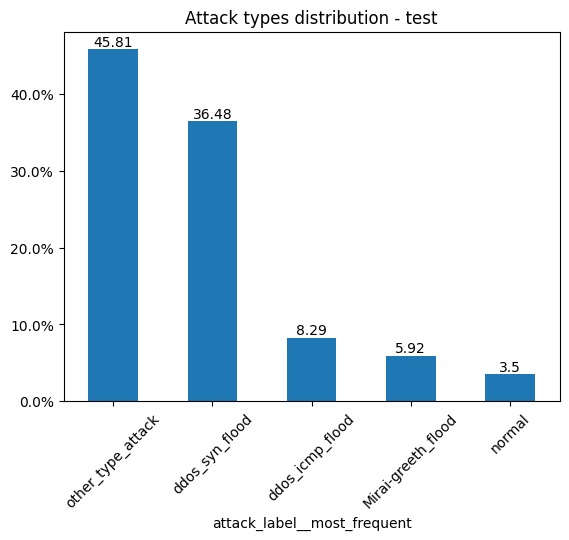

In [11]:
ax = df_test['attack_label__most_frequent'].value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - test')

Text(0.5, 1.0, 'Attack types distribution - training (before preprocessing)')

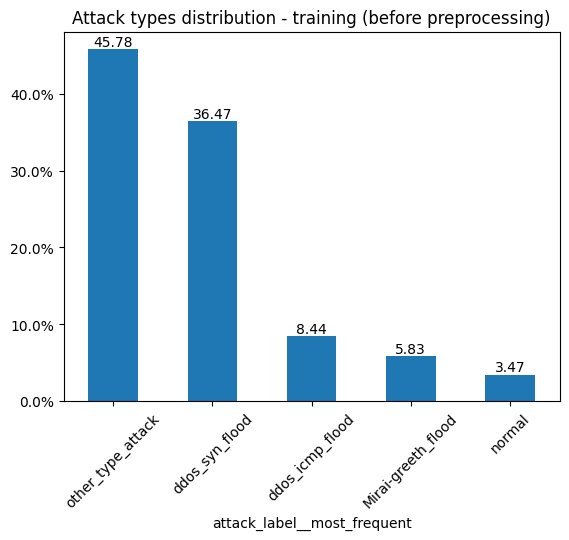

In [12]:
ax = df_train['attack_label__most_frequent'].sample(500_000).to_pandas().value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - training (before preprocessing)')

In [13]:
n_balance = int(df_train.shape[0]*0.035)
n_balance

77739

In [ ]:
"""Google Colab may not have enough RAM memory"""
df_train_normal = df_train.filter(pl.col('attack_label__most_frequent') == 'normal')
df_train_mirai = df_train.filter(pl.col('attack_label__most_frequent') == 'Mirai-greeth_flood')
df_train_icmp = df_train.filter(pl.col('attack_label__most_frequent') == 'ddos_icmp_flood')
df_train_syn = df_train.filter(pl.col('attack_label__most_frequent') == 'ddos_syn_flood')
df_train_others = df_train.filter(pl.col('attack_label__most_frequent') == 'other_type_attack')

In [33]:
df_train_mirai = df_train_mirai.sample(n_balance, seed=SEED)
df_train_icmp = df_train_icmp.sample(n_balance, seed=SEED)
df_train_syn = df_train_syn.sample(n_balance, seed=SEED)
df_train_others = df_train_others.sample(n_balance, seed=SEED)

In [ ]:
df_train = pl.concat([
    df_train_normal,
    df_train_mirai,
    df_train_icmp,
    df_train_syn,
    df_train_others
], how='vertical')
print(df_train.shape)
df_train.head()

In [ ]:
# save preprocessed splits to disk
df_test.to_csv('BRUIIoT_test_preprocessed.csv', index=False)
df_train.to_pandas().to_csv('BRUIIoT_train_preprocessed.csv', index=False)

In [2]:
# restore preprocessed data splits
df_test = pd.read_csv('BRUIIoT_test_preprocessed.csv')
df_train = pd.read_csv('BRUIIoT_train_preprocessed.csv')

In [3]:
print(df_train.shape)
df_train.head()

(388587, 268)


,frame.time__calculate_duration,ip.src_host__nunique,ip.dst_host__nunique,arp.dst.proto_ipv4__nunique,arp.opcode__min,arp.opcode__max,arp.opcode__sum,arp.opcode__mean,arp.opcode__min_max_diff,arp.opcode__min_max_ratio,...,mqtt.topic_len__sum,mqtt.topic_len__mean,mqtt.topic_len__min_max_diff,mqtt.topic_len__min_max_ratio,mqtt.topic_len__min_max_product,mqtt.topic_len__mean_square,is_attack__most_frequent,attack_label_enc__most_frequent,attack_label__most_frequent,index
0,0.114829,3,4,1,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.7,14.0,14.0,0.0,0.49,0,0,normal,14
1,0.065294,2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0,normal,25
2,0.497400,2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0,normal,30
3,0.605607,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,1.4,14.0,14.0,0.0,1.96,0,0,normal,56
4,0.520329,2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,1.4,14.0,14.0,0.0,1.96,0,0,normal,57


### Sampling training data

In [4]:
n_desired_sample = int(df_train.shape[0]*0.1)  # 10%
n_for_each_label = int(n_desired_sample/df_train['attack_label__most_frequent'].nunique())
n_for_each_label

7771

In [5]:
df_train_normal = df_train[df_train['attack_label__most_frequent'] == 'normal']
df_train_mirai = df_train[df_train['attack_label__most_frequent'] == 'Mirai-greeth_flood']
df_train_icmp = df_train[df_train['attack_label__most_frequent'] == 'ddos_icmp_flood']
df_train_syn = df_train[df_train['attack_label__most_frequent'] == 'ddos_syn_flood']
df_train_others = df_train[df_train['attack_label__most_frequent'] == 'other_type_attack']

In [6]:
df_train_normal = df_train_normal.sample(n_for_each_label, random_state=SEED)
df_train_mirai = df_train_mirai.sample(n_for_each_label, random_state=SEED)
df_train_icmp = df_train_icmp.sample(n_for_each_label, random_state=SEED)
df_train_syn = df_train_syn.sample(n_for_each_label, random_state=SEED)
df_train_others = df_train_others.sample(n_for_each_label, random_state=SEED)

In [7]:
# df_train = df_train.sample(n=int(df_train.shape[0]*0.1), random_state=SEED)
df_train = pd.concat([
    df_train_normal,
    df_train_mirai,
    df_train_icmp,
    df_train_syn,
    df_train_others
], axis=0)
df_train = df_train.sample(frac=1, random_state=SEED).reset_index(drop=True)  # shuffle
print(df_train.shape)
df_train.head()

(38855, 268)


,frame.time__calculate_duration,ip.src_host__nunique,ip.dst_host__nunique,arp.dst.proto_ipv4__nunique,arp.opcode__min,arp.opcode__max,arp.opcode__sum,arp.opcode__mean,arp.opcode__min_max_diff,arp.opcode__min_max_ratio,...,mqtt.topic_len__sum,mqtt.topic_len__mean,mqtt.topic_len__min_max_diff,mqtt.topic_len__min_max_ratio,mqtt.topic_len__min_max_product,mqtt.topic_len__mean_square,is_attack__most_frequent,attack_label_enc__most_frequent,attack_label__most_frequent,index
0,0.001534,1,20,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0000,1,1,Mirai-greeth_flood,280595
1,0.001772,1,20,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0000,1,1,Mirai-greeth_flood,2721636
2,0.001354,1,20,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0000,1,1,Mirai-greeth_flood,1793728
3,0.001424,2,20,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0000,1,1,Mirai-greeth_flood,1057066
4,0.290301,5,4,1,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,1.35,14.0,14.0,0.0,1.8225,0,0,normal,2319602


Text(0.5, 1.0, 'Attack types distribution - training (after preprocessing)')

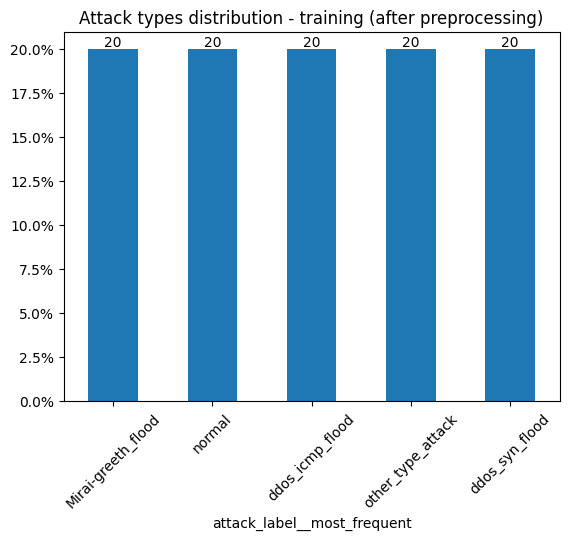

In [8]:
ax = df_train['attack_label__most_frequent'].value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - training (after preprocessing)')

In [9]:
# label columns
targets_cols = ['attack_label__most_frequent', 'attack_label_enc__most_frequent', 'is_attack__most_frequent']

In [10]:
# get protocols
modules = list(set(map(lambda x: x.split('.')[0], df_train.columns)))  # get protocols from columns
modules = [m for m in modules if m not in targets_cols]  # remove target columns
modules.remove('frame')
modules.remove('index')
modules

['arp', 'udp', 'http', 'dns', 'tcp', 'icmp', 'mqtt', 'ip']

In [11]:
df_train.isnull().sum()

,0
frame.time__calculate_duration,0
ip.src_host__nunique,0
ip.dst_host__nunique,0
arp.dst.proto_ipv4__nunique,0
arp.opcode__min,0
...,...
mqtt.topic_len__mean_square,0
is_attack__most_frequent,0
attack_label_enc__most_frequent,0
attack_label__most_frequent,0


In [12]:
def filter_module(columns, module):
    match_module = map(lambda x: x if module+'.' in x else None, columns)  # match module columns else None
    clean_module = filter(lambda x: x is not None, match_module)  # remove None values
    return list(clean_module)

## 5. Data splits

In [13]:
# map label indices
labels = list(set(zip(df_train['attack_label_enc__most_frequent'], df_train['attack_label__most_frequent'])))  # get encoding and label pairs
labels = {x[0]: x[1] for x in labels}  # to dict
labels = dict(sorted(labels.items()))  # order by key (enconding)
labels

{0: 'normal',
 1: 'Mirai-greeth_flood',
 2: 'ddos_icmp_flood',
 3: 'ddos_syn_flood',
 4: 'other_type_attack'}

In [14]:
df_test = df_test.drop(columns=['frame.time__calculate_duration'])
df_train = df_train.drop(columns=['frame.time__calculate_duration'])

In [15]:
# get features and targets
X_train = df_train.drop(columns=targets_cols+['index'])
y_train = df_train.loc[:, 'attack_label_enc__most_frequent']

X_test = df_test.drop(columns=targets_cols+['index'])
y_test = df_test.loc[:, 'attack_label_enc__most_frequent']

print('Training features size:', X_train.shape)
print('Test features size:', X_test.shape)
print('Training labels size:', y_train.shape)
print('Test labels size:', y_test.shape)

Training features size: (38855, 263)
Test features size: (555284, 263)
Training labels size: (38855,)
Test labels size: (555284,)


In [16]:
def calculate_inference_time(predictor, X_test, num_exec=100):
    times = []
    print('Doing inference test...')
    for _ in tqdm(range(num_exec)):
        tic = time.time()
        predictor.predict(X_test)
        tac = time.time()

        inference_time = tac-tic
        times.append(inference_time)

    return pd.Series(times)


def train_xgboost(X_train, y_train, X_test, y_test, method_name=None):
    # clf = XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.01, random_state=SEED)
    clf = XGBClassifier(random_state=SEED)
    clf.fit(X_train, y_train)

    # inference test
    times = calculate_inference_time(clf, X_test, num_exec=10)
    print(f'Test inference time for {X_test.shape[0]} samples in seconds:')
    print(times.describe())
    sns.boxplot(y=times)
    plt.title('Test inference time distribution')
    plt.show()

    # predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    # generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.values()))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f'Confusion matrix: {method_name}')
    plt.show()

    # metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

    print('Test accuracy:', acc)
    print('Test precision:', precision)
    print('Test recall:', recall)
    print('Test f1-score:', f1)
    print('Test ROC-AUC:', roc_auc)

## 6. Training with all features

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      8.750192
std       1.172555
min       6.919393
25%       7.737401
50%       9.138790
75%       9.486897
max      10.651809
dtype: float64


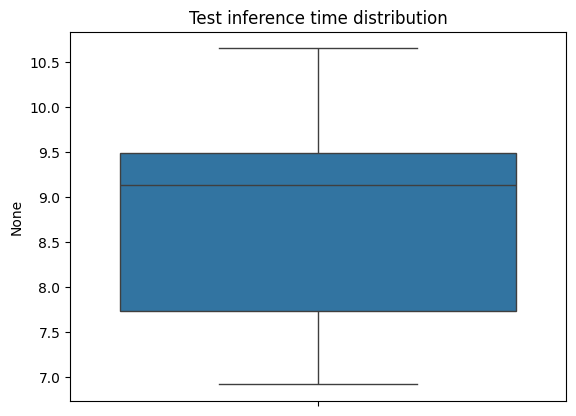

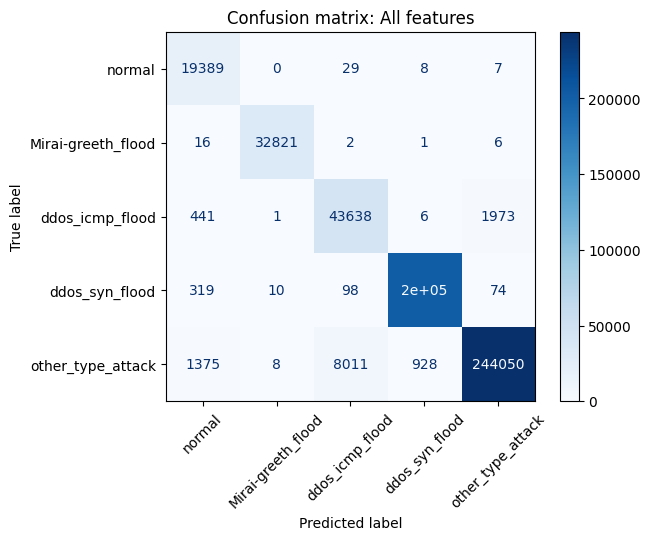

Test accuracy: 0.9760248809618142
Test precision: 0.9458671784572837
Test recall: 0.9802720259382749
Test f1-score: 0.9619026077902444
Test ROC-AUC: 0.9988385439118452


In [17]:
train_xgboost(X_train, y_train, X_test, y_test, method_name='All features')

Best model (XGBoost) from authors:
- accuracy of 99.52%
- precision of 98.20%
- recall of 98.13%
- F1-score of 98.17%

## 7. Training with random features

TODO: see p-value...

In [18]:
random_cols = X_train.sample(16, axis=1, random_state=SEED).columns
random_cols

Index(['dns.qry.qu__max', 'arp.hw.size__mean',
       'udp.time_delta__calculate_duration', 'mqtt.conflags__min',
       'mqtt.topic_len__min_max_product', 'tcp.ack__min_max_product',
       'tcp.dstport__mean_square', 'arp.hw.size__min_max_product',
       'tcp.connection.fin__min', 'dns.qry.qu__min_max_ratio',
       'tcp.connection.fin__max', 'mqtt.hdrflags__nunique', 'icmp.seq_le__sum',
       'tcp.len__min_max_diff', 'dns.retransmit_request__mean',
       'http.response__sum'],
      dtype='object')

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.800501
std       1.567693
min       5.006415
25%       5.404894
50%       6.909393
75%       7.483169
max       9.960500
dtype: float64


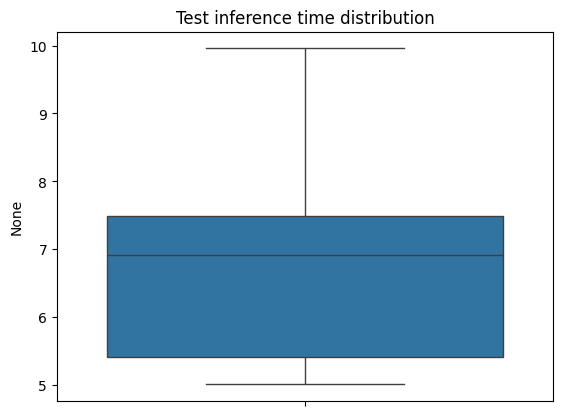

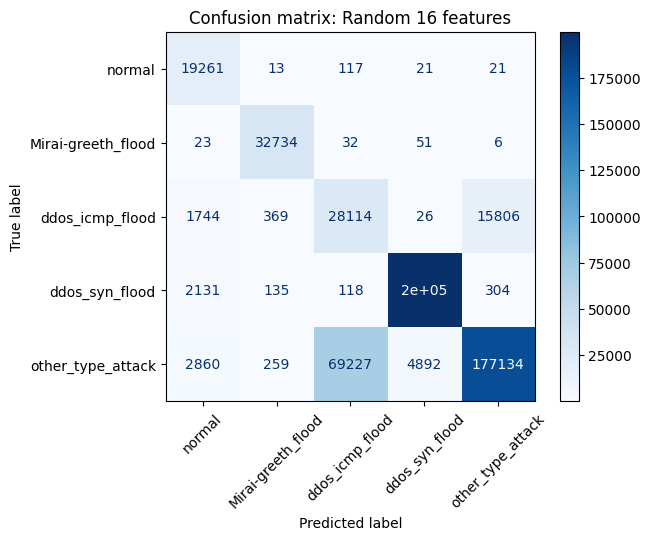

Test accuracy: 0.8232345970710483
Test precision: 0.7794577548760785
Test recall: 0.856243821828693
Test f1-score: 0.7996179581435305
Test ROC-AUC: 0.9642985448549151


In [19]:
train_xgboost(X_train.loc[:, random_cols], y_train, X_test.loc[:, random_cols], y_test, method_name='Random 16 features')

## 8. Feature selection

In [20]:
for m in modules:
    print(f'**Processing module {m}...**')

    # get module's columns
    cols = filter_module(df_train.columns, m)
    print(f'Columns length: {len(cols)}, columns:', cols)
    print('')

**Processing module arp...**
Columns length: 18, columns: ['arp.dst.proto_ipv4__nunique', 'arp.opcode__min', 'arp.opcode__max', 'arp.opcode__sum', 'arp.opcode__mean', 'arp.opcode__min_max_diff', 'arp.opcode__min_max_ratio', 'arp.opcode__min_max_product', 'arp.opcode__mean_square', 'arp.hw.size__min', 'arp.hw.size__max', 'arp.hw.size__sum', 'arp.hw.size__mean', 'arp.hw.size__min_max_diff', 'arp.hw.size__min_max_ratio', 'arp.hw.size__min_max_product', 'arp.hw.size__mean_square', 'arp.src.proto_ipv4__nunique']

**Processing module udp...**
Columns length: 11, columns: ['udp.port__nunique', 'udp.stream__nunique', 'udp.time_delta__min', 'udp.time_delta__max', 'udp.time_delta__sum', 'udp.time_delta__mean', 'udp.time_delta__calculate_duration', 'udp.time_delta__min_max_diff', 'udp.time_delta__min_max_ratio', 'udp.time_delta__min_max_product', 'udp.time_delta__mean_square']

**Processing module http...**
Columns length: 21, columns: ['http.file_data__nunique', 'http.content_length__min', 'http

### 8.1 Mutual Information (MI)

In [21]:
def fs_mutual_information(X_train, y_train):
    # mutual information
    mi_measures = mutual_info_classif(X_train, y_train, random_state=SEED)

    # plot mutual information distribution
    sns.histplot(mi_measures)
    plt.show()

    # determine threshold
    third_quartile = np.quantile(mi_measures, 0.75)

    # select features
    mask = (mi_measures > third_quartile)[:, None]
    col_idx = np.where(np.any(mask, axis=1))[0]

    selected_features = X_train.iloc[:, col_idx].columns
    return selected_features

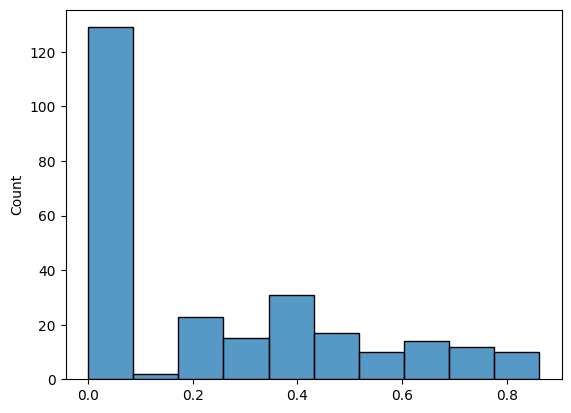

CPU times: user 1min 4s, sys: 115 ms, total: 1min 4s
Wall time: 1min 6s


(66,
 Index(['ip.src_host__nunique', 'ip.dst_host__nunique',
        'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
        'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
        'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
        'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
        'icmp.seq_le__mean_square', 'tcp.ack__max', 'tcp.ack__sum',
        'tcp.ack__mean', 'tcp.ack__min_max_diff', 'tcp.ack__min_max_ratio',
        'tcp.ack__mean_square', 'tcp.ack_raw__max', 'tcp.ack_raw__sum',
        'tcp.ack_raw__mean', 'tcp.ack_raw__min_max_diff',
        'tcp.ack_raw__min_max_ratio', 'tcp.ack_raw__mean_square',
        'tcp.checksum__min', 'tcp.checksum__max', 'tcp.checksum__sum',
        'tcp.checksum__mean', 'tcp.checksum__min_max_diff',
        'tcp.checksum__min_max_ratio', 'tcp.checksum__min_max_product',
        'tcp.checksum__mean_square', 'tcp.connection.syn__sum',
        'tcp.connection.syn__mean', 'tcp.connection.syn__mean_squ

In [22]:
%%time
mi_features = fs_mutual_information(X_train, y_train)
len(mi_features), mi_features

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      7.018874
std       1.451297
min       5.450383
25%       5.693954
50%       7.024991
75%       8.261834
max       8.768333
dtype: float64


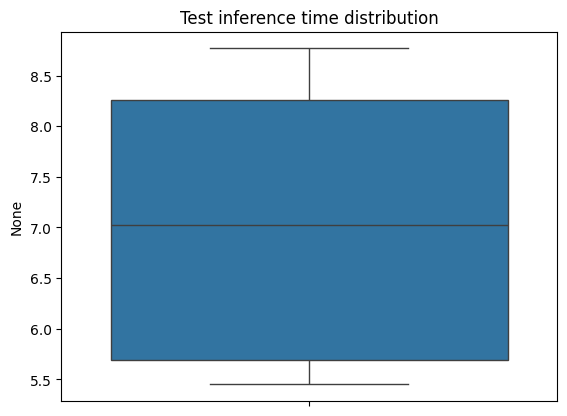

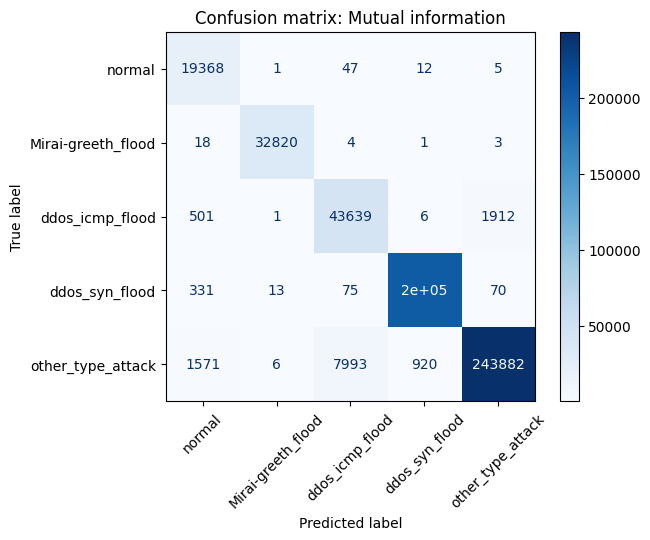

Test accuracy: 0.9757061251539753
Test precision: 0.9437332187663345
Test recall: 0.9799339094796331
Test f1-score: 0.9605532643723773
Test ROC-AUC: 0.9988059163512301


In [23]:
train_xgboost(X_train.loc[:, mi_features], y_train, X_test.loc[:, mi_features], y_test, method_name='Mutual information')

### 8.2 Causality Markov Blanket

In [24]:
def fs_causal_markov_blanket(X_train, y_train, protocols, thresholds=[0.01, 0.001], val_size=0.2, verbose=0):
    # predictor = RandomForestClassifier(n_jobs=-1)
    predictor = DecisionTreeClassifier()

    ### first, select features for each protocol ###
    selected_features = []
    for m in tqdm(protocols):
        cols = filter_module(X_train.columns, m)
        X_train_protocol = X_train[cols].reset_index(drop=True)

        model = PPIMBC(
            model=predictor,
            p_val_thresh=thresholds[0],
            num_simul=5,
            simul_size=val_size,  # validation set size
            simul_type=0,
            sig_test_type='parametric',
            cv=0,
            n_jobs=-1,
            random_state=SEED,
            verbose=verbose,
        )
        model.fit_transform(X_train_protocol, y_train.values)
        selected_features.extend(model.MB)

    print('Intermediate number of selected features:', len(selected_features))
    print('Running final selection...')

    ### finally, select the features globally ###
    model = PPIMBC(
        model=predictor,
        p_val_thresh=thresholds[1],
        num_simul=5,
        simul_size=val_size,  # validation set size
        simul_type=0,
        sig_test_type='parametric',
        cv=0,
        n_jobs=-1,
        random_state=SEED,
        verbose=verbose,
    )
    model.fit_transform(X_train[selected_features].T.reset_index(drop=True).T, y_train.values)

    # select features
    selected_features = X_train[selected_features].iloc[:, model.MB].columns

    # plot mutual information distribution
    model.MB = selected_features
    model.feature_importance()
    plt.show()

    return selected_features

  0%|          | 0/8 [00:00<?, ?it/s]

Intermediate number of selected features: 59
Running final selection...


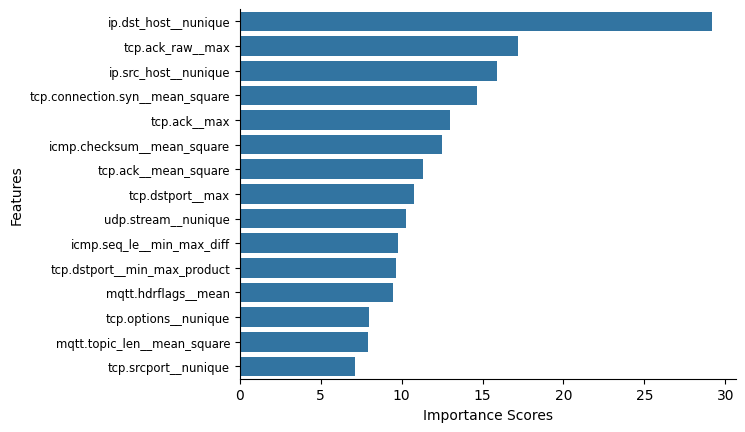

CPU times: user 12.4 s, sys: 3.25 s, total: 15.6 s
Wall time: 12min 11s


(15,
 Index(['ip.dst_host__nunique', 'tcp.ack_raw__max', 'ip.src_host__nunique',
        'tcp.connection.syn__mean_square', 'tcp.ack__max',
        'icmp.checksum__mean_square', 'tcp.ack__mean_square',
        'tcp.dstport__max', 'udp.stream__nunique', 'icmp.seq_le__min_max_diff',
        'tcp.dstport__min_max_product', 'mqtt.hdrflags__mean',
        'tcp.options__nunique', 'mqtt.topic_len__mean_square',
        'tcp.srcport__nunique'],
       dtype='object'))

In [25]:
%%time
causal_selected_features = fs_causal_markov_blanket(X_train, y_train, modules, thresholds=[0.01, 0.001], val_size=0.1)
len(causal_selected_features), causal_selected_features

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.429717
std       1.662650
min       4.799671
25%       4.829114
50%       6.314279
75%       7.723259
max       9.380168
dtype: float64


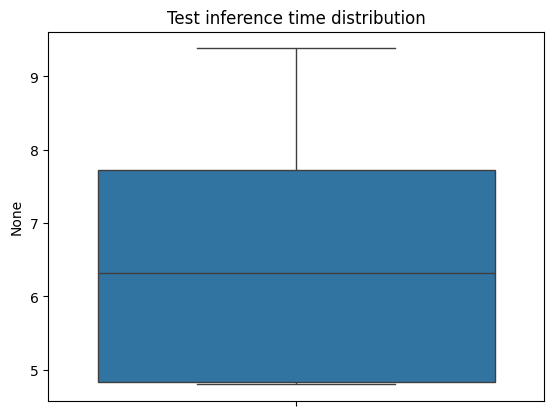

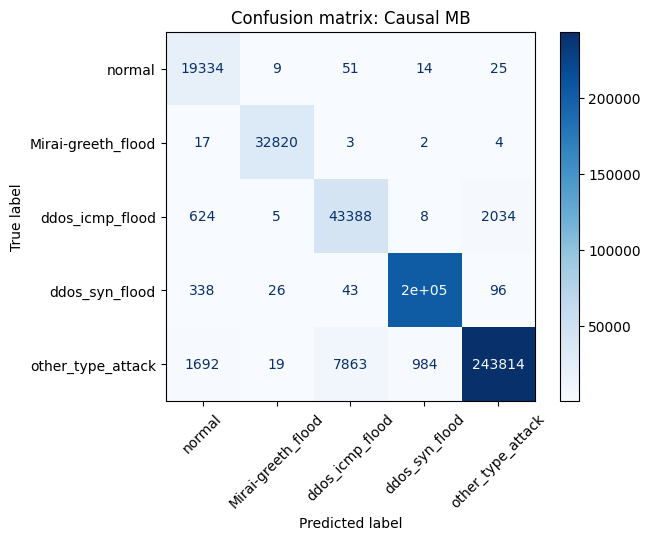

Test accuracy: 0.975045202094784
Test precision: 0.9416124844278778
Test recall: 0.9784267957030341
Test f1-score: 0.9587157111540998
Test ROC-AUC: 0.9986553399827504


In [26]:
train_xgboost(X_train.loc[:, causal_selected_features], y_train, X_test.loc[:, causal_selected_features], y_test, method_name='Causal MB')

### 8.3 Recursive Feature Elimination (RFE)

In [27]:
def fs_rfe(X_train, y_train, n_features_to_select):
    # recursive feature elimination
    # clf = RandomForestClassifier(n_jobs=-1)
    clf = DecisionTreeClassifier()
    selector = RFE(clf, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X_train, y_train)

    # select features
    selected_features = X_train.iloc[:, selector.support_].columns
    return selected_features

In [28]:
%%time
rfe_selected_features = fs_rfe(X_train, y_train, n_features_to_select=15)
len(rfe_selected_features), rfe_selected_features

CPU times: user 10min 16s, sys: 967 ms, total: 10min 17s
Wall time: 10min 40s


(15,
 Index(['ip.src_host__nunique', 'ip.dst_host__nunique', 'icmp.checksum__max',
        'icmp.checksum__mean_square', 'icmp.seq_le__mean',
        'icmp.seq_le__min_max_diff', 'icmp.seq_le__min_max_ratio',
        'tcp.ack__max', 'tcp.ack_raw__min_max_diff', 'tcp.dstport__max',
        'tcp.dstport__min_max_ratio', 'tcp.options__nunique', 'tcp.seq__max',
        'udp.stream__nunique', 'mqtt.len__mean_square'],
       dtype='object'))

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      5.759592
std       1.165577
min       4.802747
25%       4.824714
50%       5.247472
75%       6.576723
max       7.995563
dtype: float64


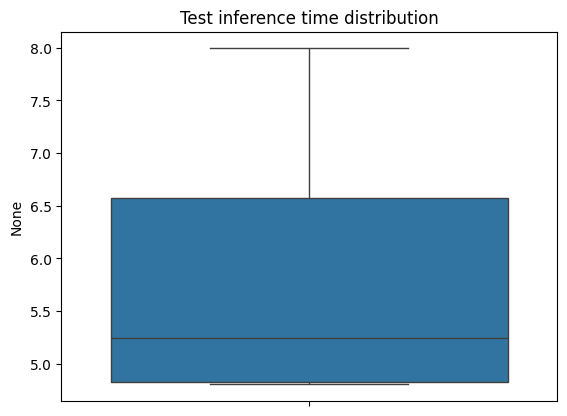

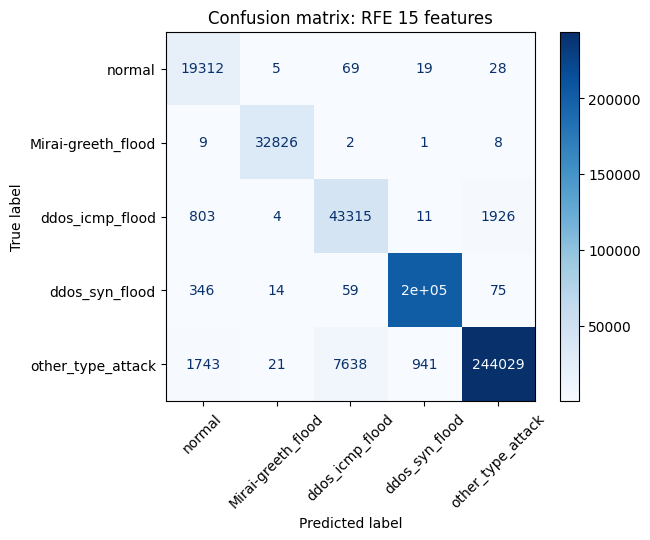

Test accuracy: 0.9752883209312712
Test precision: 0.940586146327521
Test recall: 0.978097855521473
Test f1-score: 0.9579793810260103
Test ROC-AUC: 0.9986896464894996


In [29]:
train_xgboost(X_train.loc[:, rfe_selected_features], y_train, X_test.loc[:, rfe_selected_features], y_test, method_name='RFE 15 features')

### 8.4 Boruta

In [30]:
def fs_boruta(X_train, y_train, max_iter=30, n_estimators=100):
    # boruta
    clf = RandomForestClassifier(n_jobs=-1)
    # clf = DecisionTreeClassifier()
    boruta = BorutaPy(clf, max_iter=max_iter, n_estimators=n_estimators, random_state=SEED, verbose=2)
    boruta.fit_transform(X_train.values, y_train.values)

    # select features
    cols_selected = boruta.support_.tolist()
    selected_features = X_train.iloc[:, cols_selected].columns
    return selected_features

In [31]:
%%time
boruta_selected_features = fs_boruta(X_train, y_train, max_iter=15, n_estimators=100)
len(boruta_selected_features), boruta_selected_features

Iteration: 	1 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	2 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	3 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	4 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	5 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	6 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	7 / 15
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	8 / 15
Confirmed: 	89
Tentative: 	52
Rejected: 	122
Iteration: 	9 / 15
Confirmed: 	89
Tentative: 	52
Rejected: 	122
Iteration: 	10 / 15
Confirmed: 	89
Tentative: 	52
Rejected: 	122
Iteration: 	11 / 15
Confirmed: 	89
Tentative: 	52
Rejected: 	122
Iteration: 	12 / 15
Confirmed: 	96
Tentative: 	45
Rejected: 	122
Iteration: 	13 / 15
Confirmed: 	96
Tentative: 	45
Rejected: 	122
Iteration: 	14 / 15
Confirmed: 	96
Tentative: 	45
Rejected: 	122


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	96
Tentative: 	25
Rejected: 	142
CPU times: user 7m

(96,
 Index(['ip.src_host__nunique', 'ip.dst_host__nunique', 'icmp.checksum__min',
        'icmp.checksum__max', 'icmp.checksum__sum', 'icmp.checksum__mean',
        'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
        'icmp.checksum__min_max_product', 'icmp.checksum__mean_square',
        'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
        'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
        'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
        'icmp.seq_le__mean_square', 'http.file_data__nunique',
        'http.content_length__max', 'http.content_length__sum',
        'http.content_length__mean', 'http.content_length__min_max_diff',
        'http.content_length__min_max_ratio',
        'http.content_length__mean_square', 'http.request.version__nunique',
        'http.response__min_max_diff', 'tcp.ack__max', 'tcp.ack__sum',
        'tcp.ack__mean', 'tcp.ack__min_max_diff', 'tcp.ack__min_max_ratio',
        'tcp.ack__mean_square', 

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      7.954035
std       2.470517
min       5.881187
25%       5.935895
50%       7.287973
75%       8.723285
max      13.014540
dtype: float64


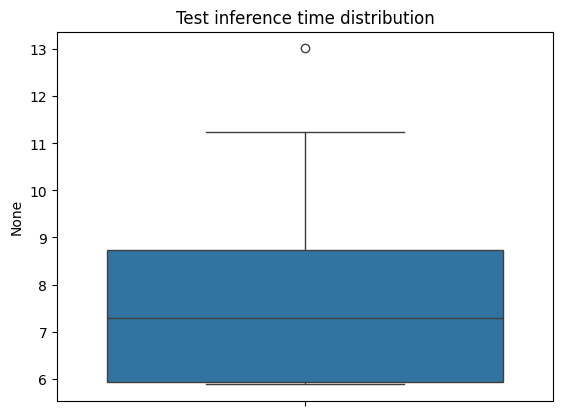

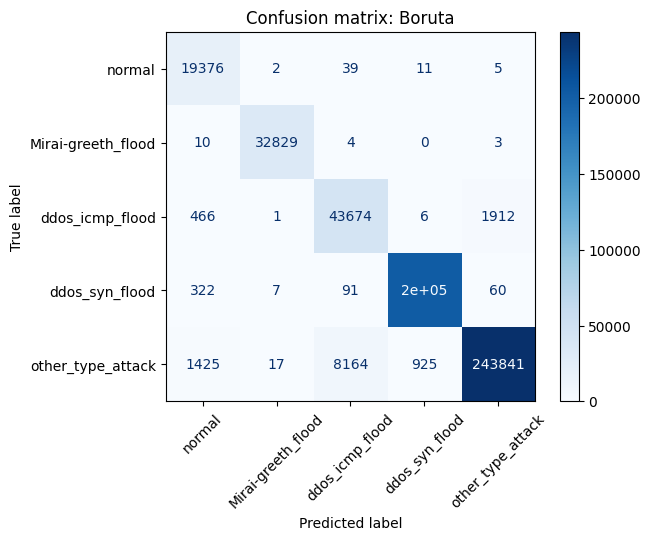

Test accuracy: 0.9757421427593808
Test precision: 0.9447799385280831
Test recall: 0.9801996732197595
Test f1-score: 0.9612540028488891
Test ROC-AUC: 0.9988369249994659


In [32]:
train_xgboost(X_train.loc[:, boruta_selected_features], y_train, X_test.loc[:, boruta_selected_features], y_test, method_name='Boruta')

## 9. Other experiments

### 9.1 Remove IP information

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      8.927180
std       2.236375
min       6.945237
25%       6.983683
50%       8.609071
75%      10.072425
max      13.364450
dtype: float64


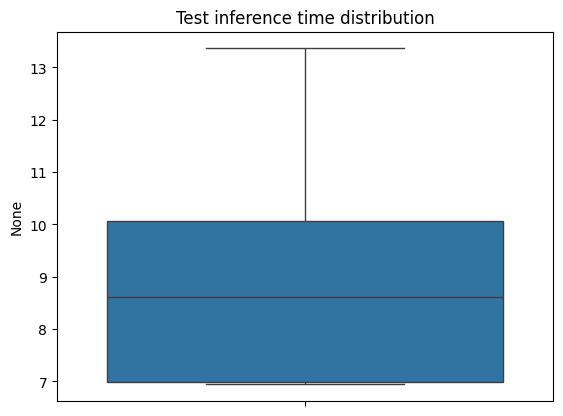

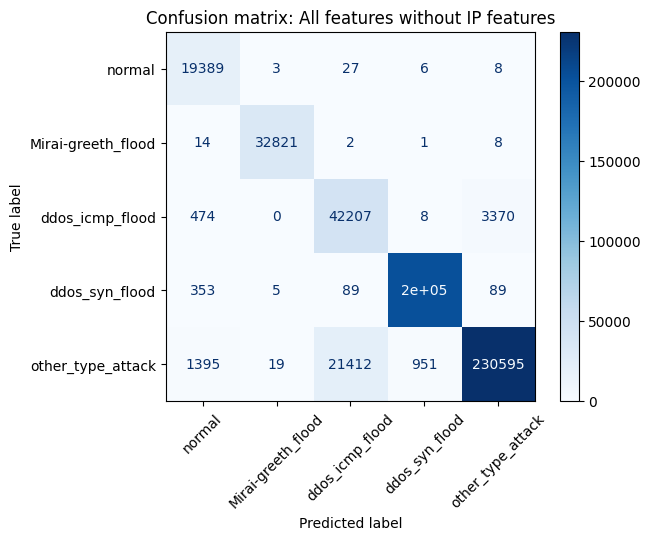

Test accuracy: 0.9491539464490243
Test precision: 0.9076760602587566
Test recall: 0.9634447068253189
Test f1-score: 0.9306011978939266
Test ROC-AUC: 0.9956935403665399


In [33]:
ip_features = filter_module(X_train.columns, 'ip')
train_xgboost(X_train.drop(columns=ip_features), y_train, X_test.drop(columns=ip_features), y_test, method_name='All features without IP features')

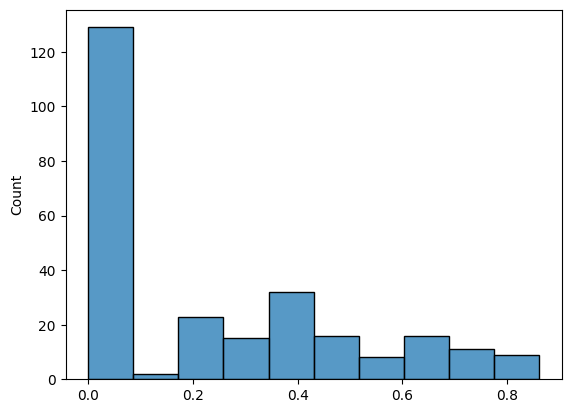

65 Index(['icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
       'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
       'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
       'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
       'icmp.seq_le__mean_square', 'tcp.ack__max', 'tcp.ack__sum',
       'tcp.ack__mean', 'tcp.ack__min_max_diff', 'tcp.ack__min_max_ratio',
       'tcp.ack__mean_square', 'tcp.ack_raw__max', 'tcp.ack_raw__sum',
       'tcp.ack_raw__mean', 'tcp.ack_raw__min_max_diff',
       'tcp.ack_raw__min_max_ratio', 'tcp.ack_raw__mean_square',
       'tcp.checksum__min', 'tcp.checksum__max', 'tcp.checksum__sum',
       'tcp.checksum__mean', 'tcp.checksum__min_max_diff',
       'tcp.checksum__min_max_ratio', 'tcp.checksum__min_max_product',
       'tcp.checksum__mean_square', 'tcp.connection.syn__sum',
       'tcp.connection.syn__mean', 'tcp.connection.syn__mean_square',
       'tcp.connection.synack__sum', 'tcp.dstport__min', 'tcp.dstp

  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.858980
std       1.170273
min       5.555231
25%       5.961938
50%       6.475211
75%       7.921902
max       8.637619
dtype: float64


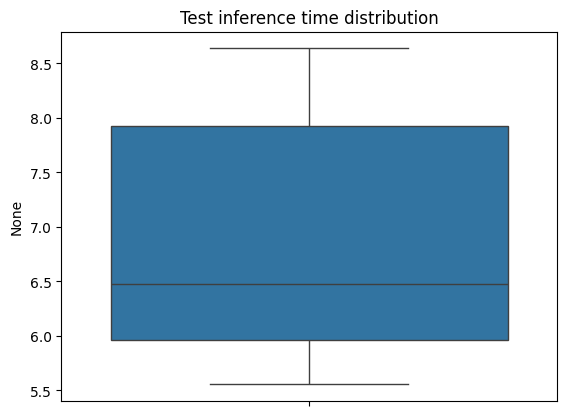

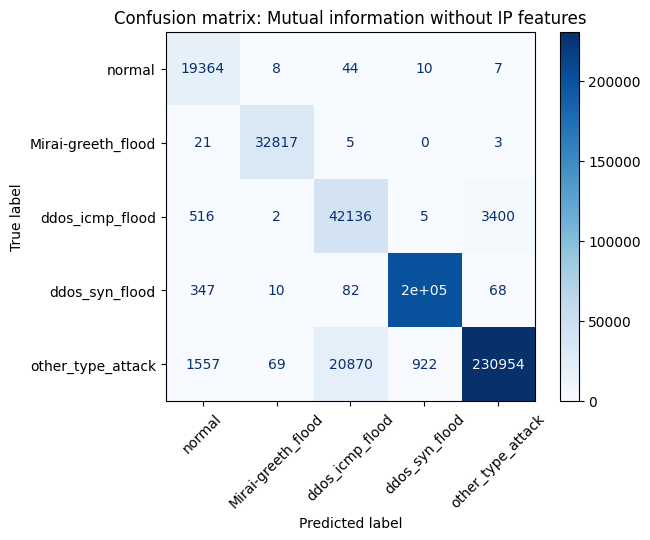

Test accuracy: 0.9496725999668638
Test precision: 0.9066542233287052
Test recall: 0.9631656515061078
Test f1-score: 0.9301009233617187
Test ROC-AUC: 0.9955655463677442
CPU times: user 3min 30s, sys: 392 ms, total: 3min 31s
Wall time: 2min 41s


In [34]:
%%time
mi_features = fs_mutual_information(X_train.drop(columns=ip_features), y_train)
print(len(mi_features), mi_features)
train_xgboost(X_train.loc[:, mi_features], y_train, X_test.loc[:, mi_features], y_test, method_name='Mutual information without IP features')

  0%|          | 0/7 [00:00<?, ?it/s]

Intermediate number of selected features: 57
Running final selection...


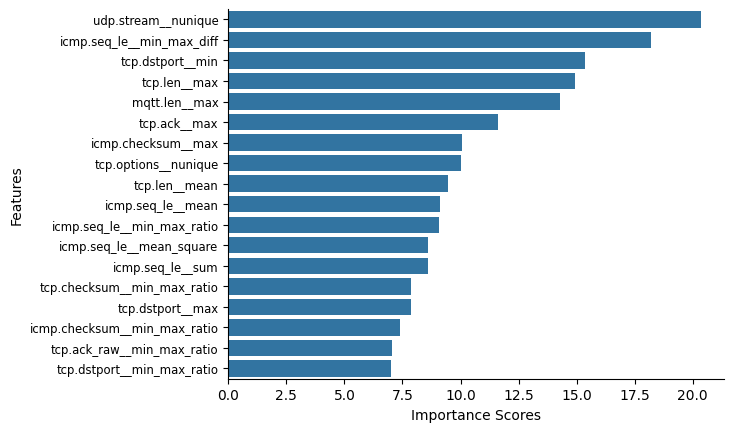

18 Index(['udp.stream__nunique', 'icmp.seq_le__min_max_diff', 'tcp.dstport__min',
       'tcp.len__max', 'mqtt.len__max', 'tcp.ack__max', 'icmp.checksum__max',
       'tcp.options__nunique', 'tcp.len__mean', 'icmp.seq_le__mean',
       'icmp.seq_le__min_max_ratio', 'icmp.seq_le__mean_square',
       'icmp.seq_le__sum', 'tcp.checksum__min_max_ratio', 'tcp.dstport__max',
       'icmp.checksum__min_max_ratio', 'tcp.ack_raw__min_max_ratio',
       'tcp.dstport__min_max_ratio'],
      dtype='object')
Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      5.929330
std       1.252548
min       4.888512
25%       4.928447
50%       5.203535
75%       6.845737
max       8.081862
dtype: float64


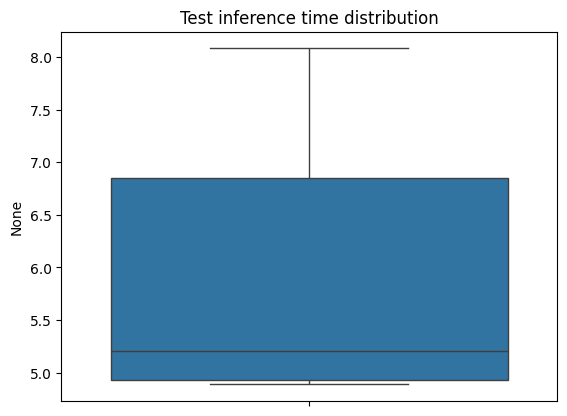

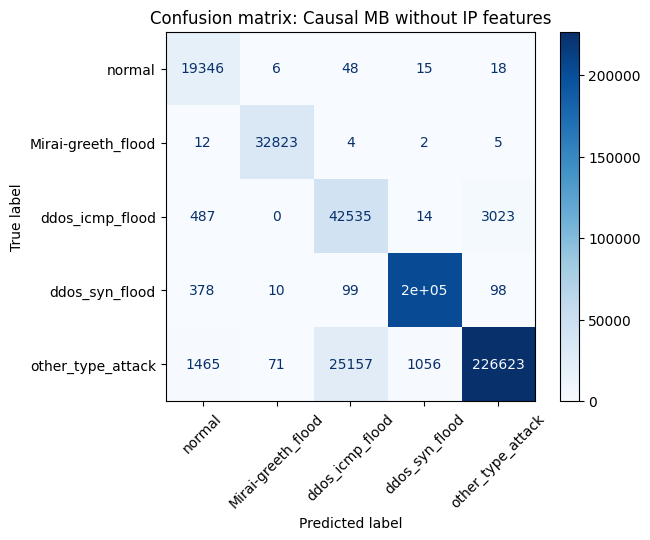

Test accuracy: 0.9424294595198133
Test precision: 0.8994593183392322
Test recall: 0.9612672362546979
Test f1-score: 0.9236391447019164
Test ROC-AUC: 0.9951738914174779
CPU times: user 2min 20s, sys: 3.25 s, total: 2min 23s
Wall time: 13min 26s


In [35]:
%%time
modules_without_ip = modules.copy()
modules_without_ip.remove('ip')

causal_selected_features = fs_causal_markov_blanket(X_train.drop(columns=ip_features), y_train, modules_without_ip, thresholds=[0.01, 0.001], val_size=0.1)
print(len(causal_selected_features), causal_selected_features)
train_xgboost(X_train.loc[:, causal_selected_features], y_train, X_test.loc[:, causal_selected_features], y_test, method_name='Causal MB without IP features')

18 Index(['icmp.checksum__max', 'icmp.checksum__mean',
       'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
       'icmp.seq_le__min_max_diff', 'icmp.seq_le__min_max_ratio',
       'icmp.seq_le__min_max_product', 'icmp.seq_le__mean_square',
       'tcp.ack_raw__max', 'tcp.ack_raw__min_max_diff', 'tcp.dstport__max',
       'tcp.dstport__min_max_product', 'tcp.dstport__mean_square',
       'tcp.len__min_max_ratio', 'tcp.options__nunique', 'tcp.seq__max',
       'udp.stream__nunique', 'mqtt.hdrflags__sum'],
      dtype='object')
Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.511844
std       1.670378
min       4.960491
25%       5.281935
50%       5.976186
75%       7.060138
max      10.321771
dtype: float64


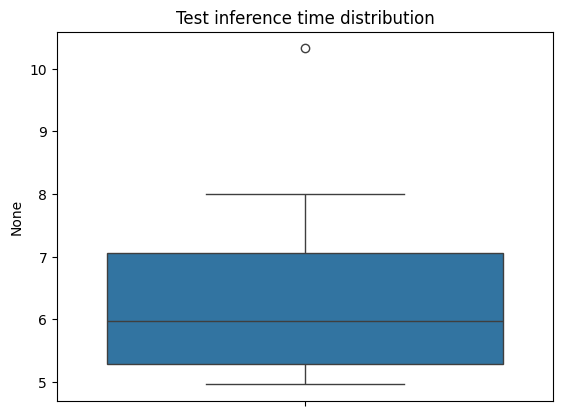

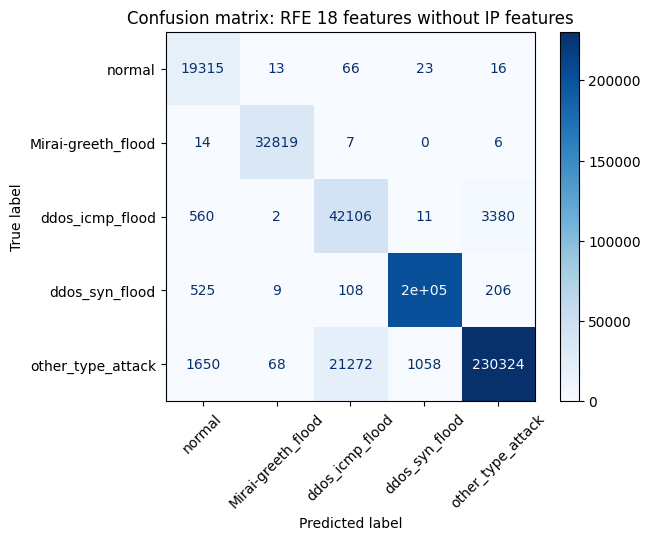

Test accuracy: 0.9477852774436144
Test precision: 0.9028552306569706
Test recall: 0.9617112604026318
Test f1-score: 0.9271820258108926
Test ROC-AUC: 0.9954173559040933
CPU times: user 11min 15s, sys: 883 ms, total: 11min 16s
Wall time: 10min 41s


In [40]:
%%time
rfe_selected_features = fs_rfe(X_train.drop(columns=ip_features), y_train, n_features_to_select=18)
print(len(rfe_selected_features), rfe_selected_features)
train_xgboost(X_train.loc[:, rfe_selected_features], y_train, X_test.loc[:, rfe_selected_features], y_test, method_name='RFE 18 features without IP features')

Iteration: 	1 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	2 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	3 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	4 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	5 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	6 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	7 / 15
Confirmed: 	0
Tentative: 	261
Rejected: 	0
Iteration: 	8 / 15
Confirmed: 	74
Tentative: 	57
Rejected: 	130
Iteration: 	9 / 15
Confirmed: 	74
Tentative: 	57
Rejected: 	130
Iteration: 	10 / 15
Confirmed: 	74
Tentative: 	57
Rejected: 	130
Iteration: 	11 / 15
Confirmed: 	74
Tentative: 	57
Rejected: 	130
Iteration: 	12 / 15
Confirmed: 	79
Tentative: 	52
Rejected: 	130
Iteration: 	13 / 15
Confirmed: 	79
Tentative: 	52
Rejected: 	130
Iteration: 	14 / 15
Confirmed: 	79
Tentative: 	49
Rejected: 	133


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	79
Tentative: 	29
Rejected: 	153
79 Index(['icmp.ch

  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      7.610010
std       1.406613
min       5.760651
25%       6.332366
50%       7.993467
75%       8.699470
max       9.686130
dtype: float64


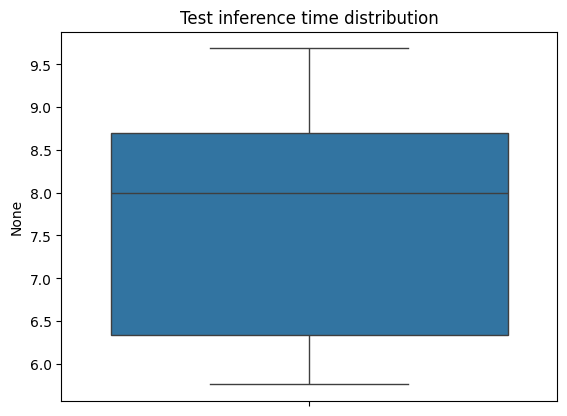

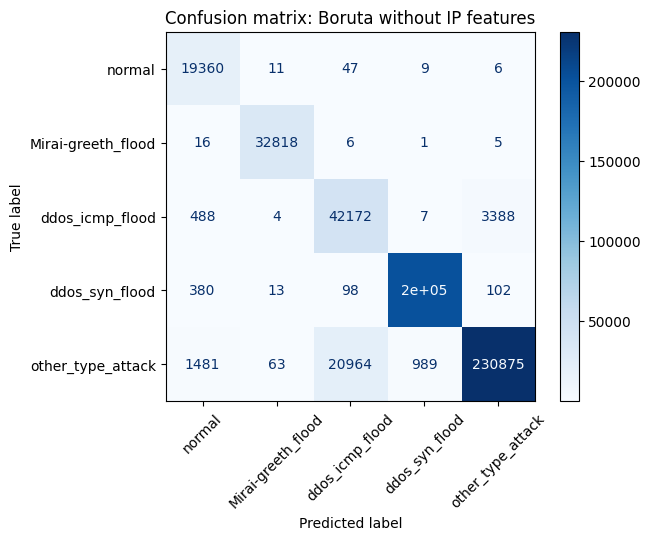

Test accuracy: 0.9494348837711873
Test precision: 0.9069683401698667
Test recall: 0.9631398736824055
Test f1-score: 0.9302245964522676
Test ROC-AUC: 0.9956264883233817
CPU times: user 10min 53s, sys: 3.21 s, total: 10min 56s
Wall time: 7min 8s


In [41]:
%%time
boruta_selected_features = fs_boruta(X_train.drop(columns=ip_features), y_train, max_iter=15, n_estimators=100)
print(len(boruta_selected_features), boruta_selected_features)
train_xgboost(X_train.loc[:, boruta_selected_features], y_train, X_test.loc[:, boruta_selected_features], y_test, method_name='Boruta without IP features')

### 9.2 Use only UDP or TCP features

Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      7.511545
std       1.410910
min       5.898740
25%       6.232300
50%       7.347719
75%       8.646136
max       9.775317
dtype: float64


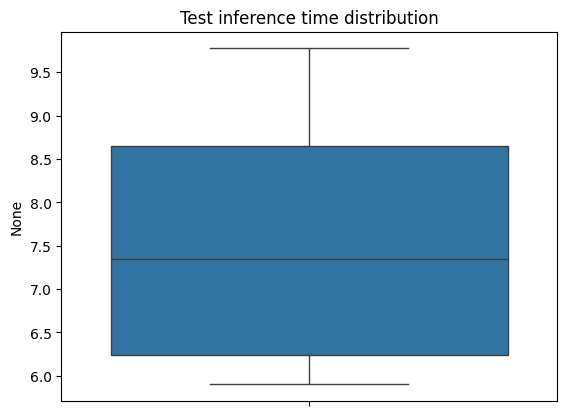

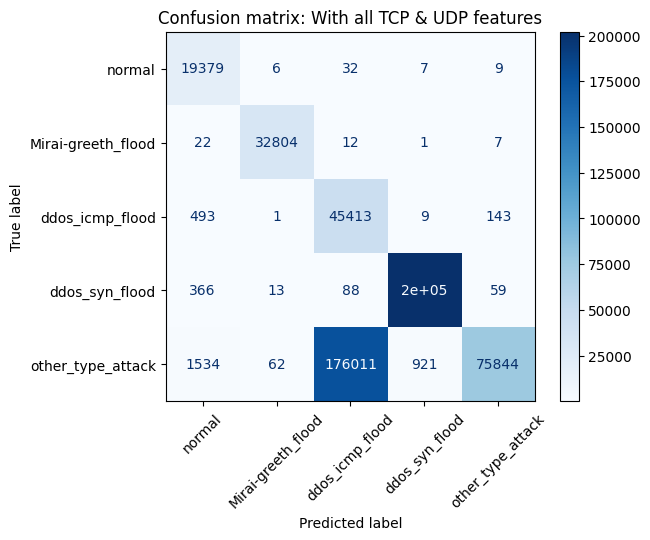

Test accuracy: 0.6762089309254363
Test precision: 0.8168364281548737
Test recall: 0.855496440689039
Test f1-score: 0.7466126420251329
Test ROC-AUC: 0.957846044686095


In [42]:
tcp_udp_features = filter_module(X_train.columns, 'tcp') + filter_module(X_train.columns, 'udp')
train_xgboost(X_train.loc[:, tcp_udp_features], y_train, X_test.loc[:, tcp_udp_features], y_test, method_name='With all TCP & UDP features')

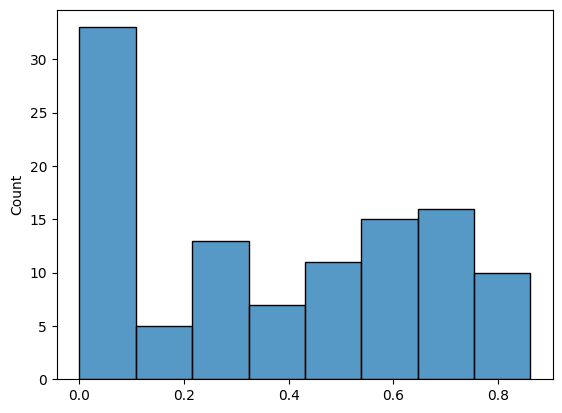

28 Index(['tcp.ack__max', 'tcp.ack__sum', 'tcp.ack__mean',
       'tcp.ack__min_max_diff', 'tcp.ack__min_max_ratio', 'tcp.ack_raw__max',
       'tcp.ack_raw__min_max_diff', 'tcp.ack_raw__min_max_ratio',
       'tcp.dstport__min', 'tcp.dstport__max', 'tcp.dstport__sum',
       'tcp.dstport__mean', 'tcp.dstport__min_max_diff',
       'tcp.dstport__min_max_ratio', 'tcp.dstport__min_max_product',
       'tcp.dstport__mean_square', 'tcp.flags__max', 'tcp.flags__sum',
       'tcp.flags__mean', 'tcp.flags__min_max_ratio', 'tcp.flags__mean_square',
       'tcp.len__max', 'tcp.len__sum', 'tcp.len__mean',
       'tcp.len__min_max_diff', 'tcp.len__min_max_ratio',
       'tcp.len__mean_square', 'tcp.seq__max'],
      dtype='object')
Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.952879
std       1.618431
min       5.344198
25%       5.373435
50%       6.850711
75%       8.383716
max       9.246679
dtype: float64


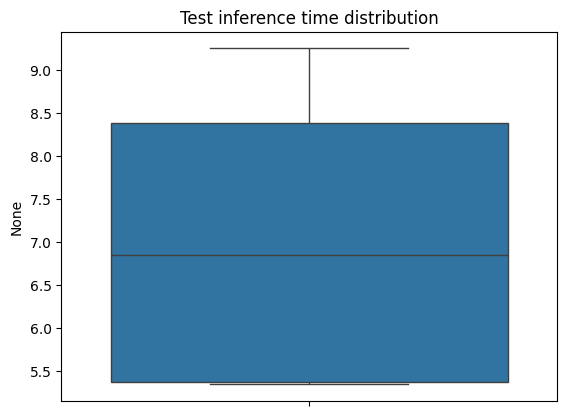

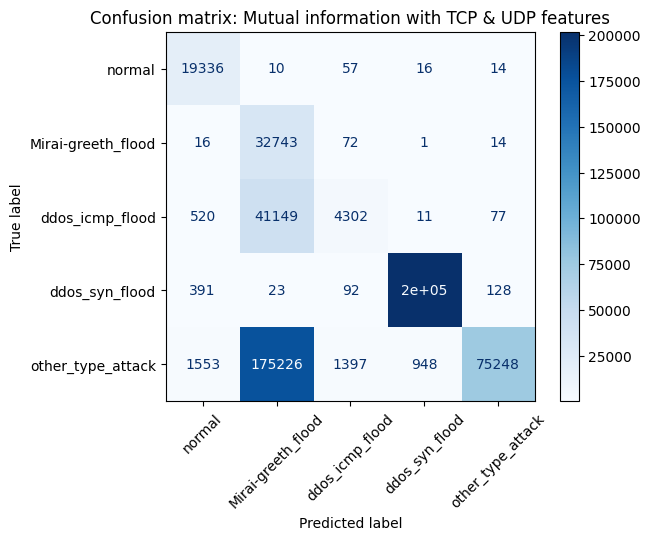

Test accuracy: 0.600717830875732
Test precision: 0.7473065419290984
Test recall: 0.6755927174640148
Test f1-score: 0.5575115385403786
Test ROC-AUC: 0.9057052082585976
CPU times: user 2min 40s, sys: 297 ms, total: 2min 40s
Wall time: 1min 54s


In [43]:
%%time
mi_features = fs_mutual_information(X_train.loc[:, tcp_udp_features], y_train)
print(len(mi_features), mi_features)
train_xgboost(X_train.loc[:, mi_features], y_train, X_test.loc[:, mi_features], y_test, method_name='Mutual information with TCP & UDP features')

  0%|          | 0/2 [00:00<?, ?it/s]

Intermediate number of selected features: 26
Running final selection...


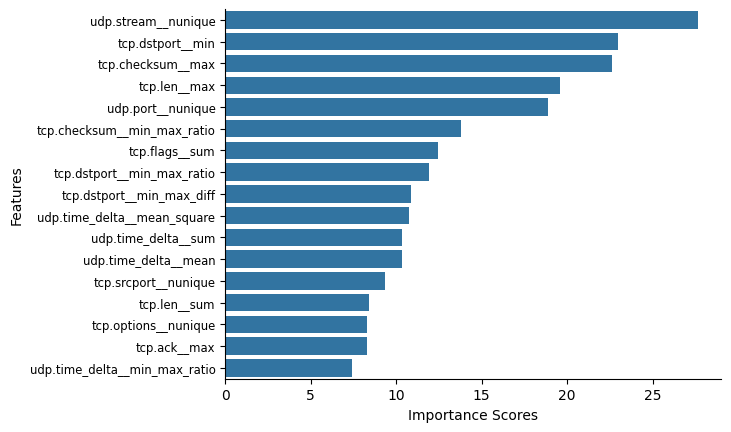

17 Index(['udp.stream__nunique', 'tcp.dstport__min', 'tcp.checksum__max',
       'tcp.len__max', 'udp.port__nunique', 'tcp.checksum__min_max_ratio',
       'tcp.flags__sum', 'tcp.dstport__min_max_ratio',
       'tcp.dstport__min_max_diff', 'udp.time_delta__mean_square',
       'udp.time_delta__sum', 'udp.time_delta__mean', 'tcp.srcport__nunique',
       'tcp.len__sum', 'tcp.options__nunique', 'tcp.ack__max',
       'udp.time_delta__min_max_ratio'],
      dtype='object')
Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.013274
std       1.415443
min       4.823922
25%       4.860612
50%       5.218473
75%       7.256068
max       8.107153
dtype: float64


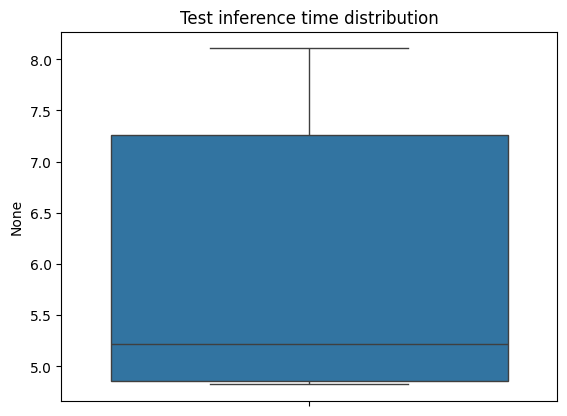

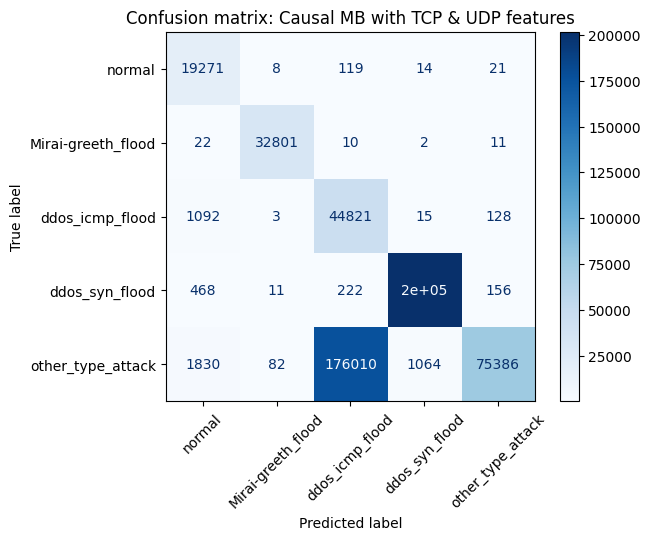

Test accuracy: 0.6735220175621844
Test precision: 0.8078976174270525
Test recall: 0.85110914964259
Test f1-score: 0.7400550651409441
Test ROC-AUC: 0.9565375077826683
CPU times: user 2min 8s, sys: 2.06 s, total: 2min 10s
Wall time: 9min 17s


In [44]:
%%time
modules_tcp_udp = ['tcp', 'udp']

causal_selected_features = fs_causal_markov_blanket(X_train.loc[:, tcp_udp_features], y_train, modules_tcp_udp, thresholds=[0.01, 0.001], val_size=0.1)
print(len(causal_selected_features), causal_selected_features)
train_xgboost(X_train.loc[:, causal_selected_features], y_train, X_test.loc[:, causal_selected_features], y_test, method_name='Causal MB with TCP & UDP features')

4 Index(['tcp.dstport__min_max_product', 'tcp.len__min_max_ratio',
       'tcp.options__nunique', 'udp.stream__nunique'],
      dtype='object')
Doing inference test...


  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.110004
std       1.293544
min       4.818566
25%       4.841475
50%       6.027968
75%       6.890693
max       8.066348
dtype: float64


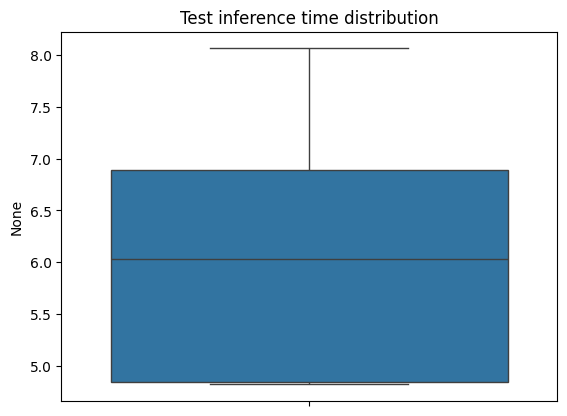

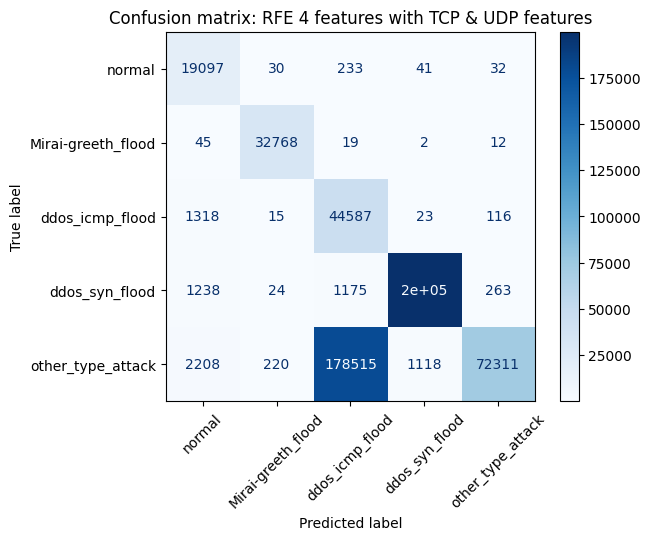

Test accuracy: 0.6638711001937747
Test precision: 0.7953940431462162
Test recall: 0.8438640546803077
Test f1-score: 0.7275551011273661
Test ROC-AUC: 0.9532721747092768
CPU times: user 4min 12s, sys: 434 ms, total: 4min 12s
Wall time: 3min 30s


In [45]:
%%time
rfe_selected_features = fs_rfe(X_train.loc[:, tcp_udp_features], y_train, n_features_to_select=4)
print(len(rfe_selected_features), rfe_selected_features)
train_xgboost(X_train.loc[:, rfe_selected_features], y_train, X_test.loc[:, rfe_selected_features], y_test, method_name='RFE 4 features with TCP & UDP features')

Iteration: 	1 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	2 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	3 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	4 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	5 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	6 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	7 / 15
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	8 / 15
Confirmed: 	33
Tentative: 	29
Rejected: 	48
Iteration: 	9 / 15
Confirmed: 	33
Tentative: 	29
Rejected: 	48
Iteration: 	10 / 15
Confirmed: 	33
Tentative: 	29
Rejected: 	48
Iteration: 	11 / 15
Confirmed: 	33
Tentative: 	29
Rejected: 	48
Iteration: 	12 / 15
Confirmed: 	35
Tentative: 	16
Rejected: 	59
Iteration: 	13 / 15
Confirmed: 	35
Tentative: 	16
Rejected: 	59
Iteration: 	14 / 15
Confirmed: 	35
Tentative: 	16
Rejected: 	59


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	35
Tentative: 	2
Rejected: 	73
35 Index(['tcp.ack__max', '

  0%|          | 0/10 [00:00<?, ?it/s]

Test inference time for 555284 samples in seconds:
count    10.000000
mean      6.317946
std       1.408514
min       5.000166
25%       5.026737
50%       5.856789
75%       7.329195
max       8.636733
dtype: float64


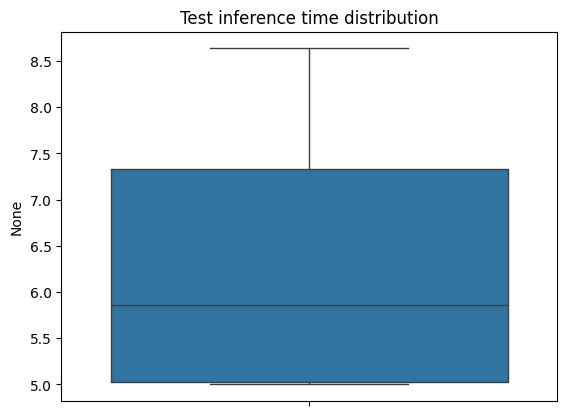

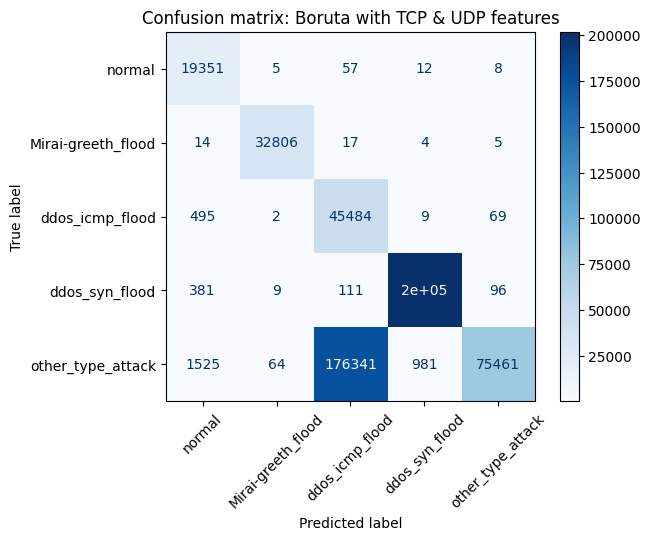

Test accuracy: 0.6754723708948934
Test precision: 0.8168357565083824
Test recall: 0.8551575177338815
Test f1-score: 0.7460566332267464
Test ROC-AUC: 0.9577321691414212
CPU times: user 9min 43s, sys: 1.93 s, total: 9min 45s
Wall time: 6min 21s


In [46]:
%%time
boruta_selected_features = fs_boruta(X_train.loc[:, tcp_udp_features], y_train, max_iter=15, n_estimators=100)
print(len(boruta_selected_features), boruta_selected_features)
train_xgboost(X_train.loc[:, boruta_selected_features], y_train, X_test.loc[:, boruta_selected_features], y_test, method_name='Boruta with TCP & UDP features')

### 9.3 Mirai attack